# Detekcija igralne površine

Postopek uporablja klasične tehnike računalnikega vida. Gre za ročno pripravljene algoritme, ki običajno delujejo dobro v nadzorovanih pogojih ampak imajo precejšnje težave v resničnih okoljih.

V našem primeru bomo izkoristili specifično pripravljen izgled posode za kocke, ki omogoča delovanje tudi v težavnejṡih razmerah.

Postopek detekcije je sledeč:

* iskanje sprememb
* segmentacija
* izločanje kontur
* izbira primerne konture

#### Naprej pripravimo okolje in uvozimo primerne knjižnice.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['figure.figsize'] = [15, 5]
import scipy.ndimage as ndimage
import cv2

#### Nato naložimo primer s katerim bomo delali.

Zaenkrat izrežimo manjši kos tega primera, da bomo lažje videli podrobnosti.

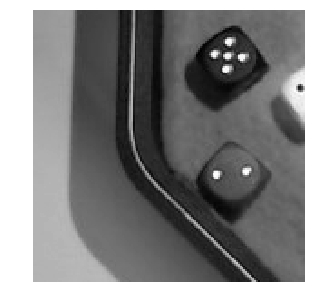

In [3]:
slika = pyplot.imread('./primer.png')
slika_siva = slika.mean(2)

slika_siva = slika_siva[150:300, 50:200]

pyplot.figure()
pyplot.imshow(slika_siva)
pyplot.axis('off');

## Iskanje robov (konvolucija)

#### Konvolucija je osnovna operacija pri obdelavi slik.

Sama operacija je izredno preprosta. Imamo našo sliko in imamo konvolucijski operator - jedro. Oba sta sestavljena iz številčnih vrednosti hranjeni v veliki 2D tabeli.

Konvolucija vzame jedro, ter ga pomika preko slike. 

Na vsaki lokaciji slike vrednosti jedra pomnoži z vrednostmi slike in jih sešteje.

Rezultat hrani v novo izhodno sliko.

Izgled izhodne slike bo odvisen od izbranega jedra.

![Animacija konvolucije na wikipediji](https://upload.wikimedia.org/wikipedia/commons/4/4f/3D_Convolution_Animation.gif)
*Animacija z Wikipedije*

[Spletna demonstracija](http://setosa.io/ev/image-kernels/)

jedro = $\begin{bmatrix}
1 & 0 & -1 \\
2 & 0 & -2 \\
1 & 0 & -1 \\
\end{bmatrix}
$

slika = 
$
\begin{bmatrix}
0 & 0 & 0 & 1 & 1 & 1 \\
0 & 0 & 0 & 1 & 1 & 1 \\
0 & 0 & 0 & 1 & 1 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 
\end{bmatrix}
$

konvolucija(slika,jedro) = 
$
\begin{bmatrix}
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 4 & 4 & 0 & 0 \\
0 & 0 & 3 & 3 & 0 & 0 \\
0 & 0 & 1 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 
\end{bmatrix}
$

In [4]:
K = np.array([[1, 0, -1],[2, 0, -2],[1, 0, -1],], dtype=int)
I = np.zeros((6,6), dtype=int)
I[:3, 3:] = 1

I_K = ndimage.convolve(I, K)

In [5]:
print('slika')
print(I)
print('jedro')
print(K)
print('konvolucija slike in jedra')
print(I_K)

slika
[[0 0 0 1 1 1]
 [0 0 0 1 1 1]
 [0 0 0 1 1 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]
jedro
[[ 1  0 -1]
 [ 2  0 -2]
 [ 1  0 -1]]
konvolucija slike in jedra
[[0 0 4 4 0 0]
 [0 0 4 4 0 0]
 [0 0 3 3 0 0]
 [0 0 1 1 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


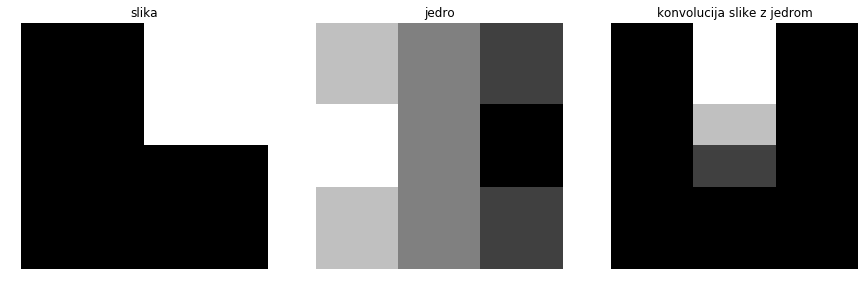

In [6]:
pyplot.figure()
pyplot.subplot(131)
pyplot.imshow(I)
pyplot.title('slika')
pyplot.axis('off')
pyplot.subplot(132)
pyplot.imshow(K)
pyplot.title('jedro')
pyplot.axis('off')
pyplot.subplot(133)
pyplot.imshow(I_K)
pyplot.title('konvolucija slike z jedrom')
pyplot.axis('off');

### Lokalno povprečje

Za izračun lokalnega povprečja želimo vrednosti slike pod jedrom sešteti nato pa delimi z številom vrednosti, ki jih jedro pokrije.

Seštevanje lahko naredimo tako, da vrednosti jedra nastavimo na 1. Glede na formulo povprečja se zdi, da bomo morali po konvoluciji opraviti še deljenje z številom elementov jedra. Vendar lahko z malo spretnosti vidite, da lahko deljenje pri računanju povprečja opravimo tudi pred seštevanjem. 

To pomeni, da vrednosti jedra že vnaprej delimo z številom elementov.

jedro = 
$
\frac{1}{N}
\cdot
\begin{bmatrix}
1 & 1 & \dots & 1 \\
1 & 1 & \dots & 1 \\
\vdots & \vdots & \ddots &1 \\
1 & 1 & 1 &  1 \\
\end{bmatrix}
$

* N - število elementov v jedru, oziroma seštevek enic

Pripravimo jedro velikosti 11x11 pikslov.

In [7]:
H = 11
W = 11
N = H*W
jedro = 1/N * np.ones((H, W))

#### Izračunajmo lokalno povprečje v sliki

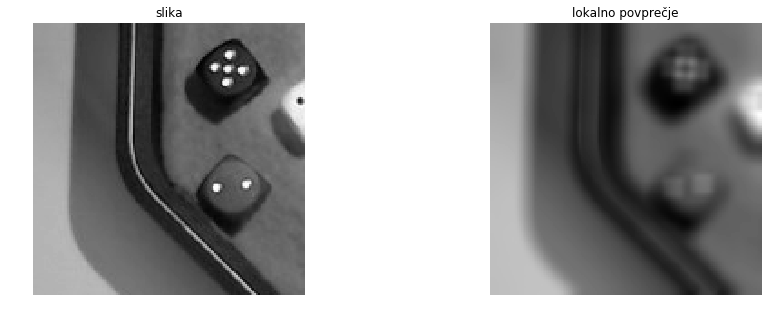

In [8]:
slika_lokalno_povp = ndimage.convolve(slika_siva, jedro)

pyplot.figure()
pyplot.subplot(121)
pyplot.imshow(slika_siva)
pyplot.title('slika')
pyplot.axis('off')
pyplot.subplot(122)
pyplot.imshow(slika_lokalno_povp)
pyplot.title('lokalno povprečje')
pyplot.axis('off');

#### Slika lokalnega povprečja ima mehke robove

V sliki lokalnega povprečja lahko opazimo:

* mehkejše prehode 
* odstranjene podrobnosti (bela črta, pike na kockah)

Slika lokalnega povprečja je **zglajena**.

#### Razlika originalne in zglajene slike 

Izračunajmo razliko med originalno in zglajeno zliko.

V sliki razlik bomo imeli **poudarjene podrobnosti**, ki v zglajeni sliki niso prisotne.

Ta preprosta tehnika nam pomaga **iskati robove** v sliki.

In [9]:
slika_robov = slika_siva-slika_lokalno_povp

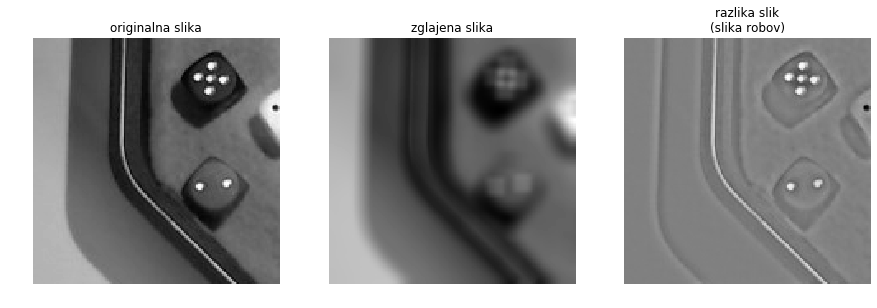

In [10]:
pyplot.figure()
pyplot.subplot(131)
pyplot.imshow(slika_siva, cmap='gray')
pyplot.title('originalna slika')
pyplot.axis('off');
pyplot.subplot(132)
pyplot.imshow(slika_lokalno_povp, cmap='gray')
pyplot.title('zglajena slika')
pyplot.axis('off');
pyplot.subplot(133)
pyplot.imshow(slika_robov, cmap='gray')
pyplot.title('razlika slik\n(slika robov)')
pyplot.axis('off');

#### Binarna slika robov

Na tem mestu bi lahko uporabili kompleksno metodo iskanja robov, ki bi v razliki slik določila njihove pozicije.

Namesto tega bomo uporabili bolj preprosto metodo - **pragovno operacijo**.

Izbrali bomo fiksen prag - $0.05$.

Ustvarili bomo masko. Vrednosti vsakega piksla bomo **primerjali s pragom**: 

* **večji bodo beli** (vrednost 1 ali True)
* **manjši bodo črni** (vrednost 0 ali False).

In [11]:
prag = 0.05
slika_robov_bin = slika_robov>prag


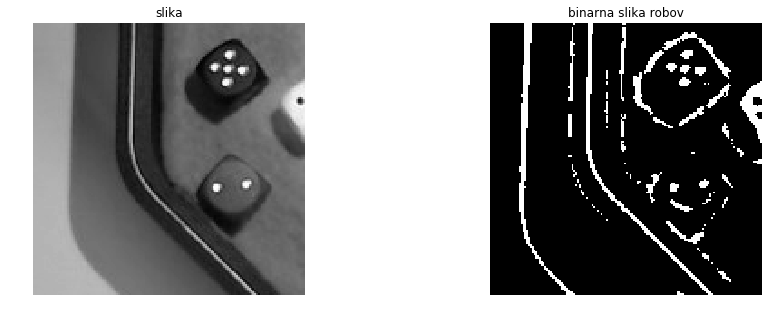

In [12]:

pyplot.figure()
pyplot.subplot(121)
pyplot.imshow(slika_siva)
pyplot.title('slika')
pyplot.axis('off')
pyplot.subplot(122)
pyplot.imshow(slika_robov_bin, cmap='gray')
pyplot.title('binarna slika robov')
pyplot.axis('off');

#### V binarni sliki jasno vidimo bel rob

Poleg tega roba, pa so v binarni sliki robov vidni drugi robovi, pike na kocka, šum, ...

Iz vseh teh elementov želimo poiskati bel rob na posodi. Izkoristili bomo njegove **geometrijske lastnosti**.

## Iskanje kontur - poligonov

Za analizo geometrijski lastnosti je smiselno elemente v sliki predstaviti na ustrezen način.

Ustrezna predstavitev so konture - poligoni, ki oklepajo regije v binarni sliki.

Tu bomo uporabili algoritme iz knjižnice OpenCv. 

#### Naložimo celotno sliko

Sedaj bomo potrebovali celotno sliko, da bo viden celoten rob.

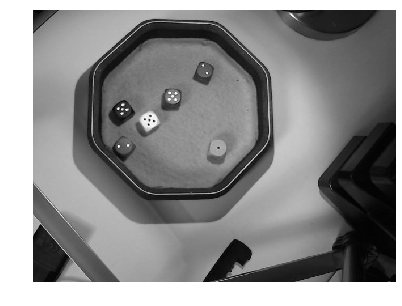

In [13]:
slika = pyplot.imread('./primer.png')
slika_siva = slika.mean(2)

pyplot.figure()
pyplot.imshow(slika_siva)
pyplot.axis('off');

#### Izračunajmo binarno sliko robov

Ponovimo sedaj zgoraj opisan postopek nad celotno sliko.

In [14]:
jedro_vel = 11
prag = 0.05
jedro = 1/(jedro_vel*jedro_vel) * np.ones((jedro_vel, jedro_vel))

slika_lokalno_povp = ndimage.convolve(slika_siva, jedro)
slika_robov = slika_siva-slika_lokalno_povp
slika_robov_bin = slika_robov>prag

#### Poglejmo si binarno sliko

Zaradi izrisa je bel rob na posodi morda slabo viden.

V tej fazi je pomembno, da je označen rob povezan cikel.

V kolikor ni, moramo prilagoditi prag segmentacije. Prag postavimo nižje, zato da zajamemo več podrobnosti (ki jih bomo kasneje izločili).

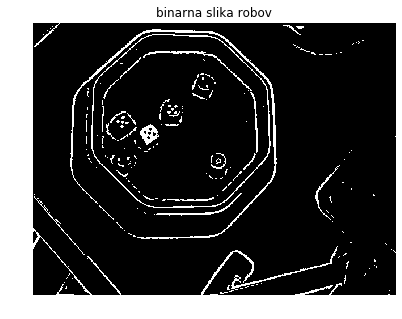

In [15]:
pyplot.figure()
pyplot.imshow(slika_robov_bin, cmap='gray')
pyplot.title('binarna slika robov')
pyplot.axis('off');

#### Poiščimo poligone


Funkcija ```cv2.findCountours``` poišče **poligone okrog belih regij** v binarni sliki.

Vrne nam sezname točk, ki poligone opisujejo. 

Vrne pa lahko tudi hierarhijo - funkcija nam lahko pove, **kateri poligoni se nahajajo znotraj drugih**. 

Pri tem lahko dobimo **celotno drevo** - poligoni v poligonih v poligonih.

Ali pa samo dvonivojski seznam - **zunanji poligon in poligoni znotraj njega**.

In [16]:
_, poligoni, hierarhija = cv2.findContours(np.uint8(slika_robov_bin),
                                           cv2.RETR_CCOMP, 
                                           cv2.CHAIN_APPROX_SIMPLE)

indeks_poli = range(len(poligoni))

### Število najdenih poligonov

Na tej točki bo število najdenih poligonov zelo visoko. Vsi ti so sedaj **kandidati za rob posode**.

In [17]:
print(f'število poligonov: {len(indeks_poli)}')

število poligonov: 301


### Izrišimo poligone

Vrnjene povezave so nekoliko kompleksne, zato je koda za izris tudi malce daljša.

**Rdeče bomo izrisali zunanje poligone.**

**Modro bomo izrisali notranje poligone.**

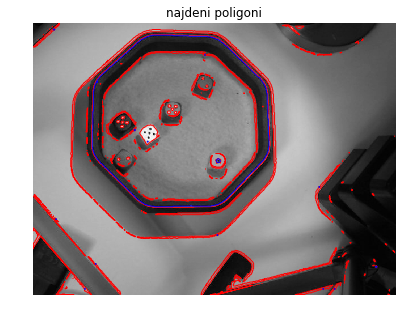

In [18]:
pyplot.figure()
ax = pyplot.gca()

ax.imshow(slika_siva)
ax.set_axis_off()
ax.set_title('najdeni poligoni')

for n in indeks_poli:
    poli = poligoni[n]
    _, _, n_znotraj, n_zunaj = hierarhija[0, n, :]
    
    
    if n_zunaj != -1:
        continue
        
    poli_patch = matplotlib.patches.Polygon(poli[:, 0, :], fill=False, ec='r')
    ax.add_artist(poli_patch)
    
    n_nasl = n_znotraj
    while n_nasl != -1:
        poli_znotraj = poligoni[n_nasl]
        poli_patch = matplotlib.patches.Polygon(poli_znotraj[:, 0, :],
                                                fill=False, ec='b')
        ax.add_artist(poli_patch)

        n_prej, n_nasl, _, _ = hierarhija[0, n_nasl, :]


#### Poiščimo vse večje poligone

Da je najden poligon zanimiv za nadaljno obdelavo mora biti dovolj velik.

Četudi je posoda dlje stran in zaradi tega manjša, z nadaljno obdelavo ne bomo mogli najti in prepoznati kock.

Ohranimo tiste poligone, katerih površina bo vsaj tako velika kot 10x10 pikslov velik kvadrat. V praksi lahko ta prag nastavimo dosti višje, na primero 100x100.

In [19]:
min_povrsina = 10*10

indeks_poli = [i for i in indeks_poli if cv2.contourArea(poligoni[i])>min_povrsina]

#### Koliko poligonov nam je še ostalo?
#### Izrišimo si rezultat

število poligonov: 16


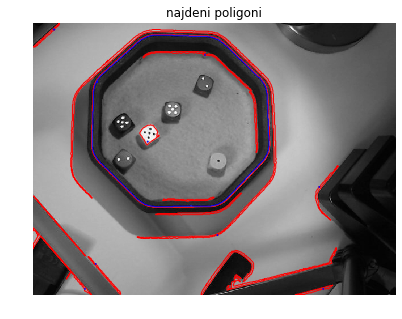

In [20]:
pyplot.figure()
ax = pyplot.gca()

ax.imshow(slika_siva)
ax.set_axis_off()
ax.set_title('najdeni poligoni')

for n in indeks_poli:
    poli = poligoni[n]
    _, _, n_znotraj, n_zunaj = hierarhija[0, n, :]
    
    
    if n_zunaj != -1:
        continue
        
    poli_patch = matplotlib.patches.Polygon(poli[:, 0, :], fill=False, ec='r')
    ax.add_artist(poli_patch)
    
    n_nasl = n_znotraj
    while n_nasl != -1:
        poli_znotraj = poligoni[n_nasl]
        poli_patch = matplotlib.patches.Polygon(poli_znotraj[:, 0, :],
                                                fill=False, ec='b')
        ax.add_artist(poli_patch)

        n_prej, n_nasl, _, _ = hierarhija[0, n_nasl, :]


print(f'število poligonov: {len(indeks_poli)}')

#### Poiščimo poligone, ki vsebujejo vsaj en poligon


Pričakujemo, da bo iskan poligon vseboval drug malo manjši poligon. Odstranimo lahko vse tiste, ki ne vsebujejo drugih poligonov.

In [21]:
indeks_poli = [i for i in indeks_poli if hierarhija[0, i, 2]!= -1]

#### Izrišimo rezultat

število poligonov: 9


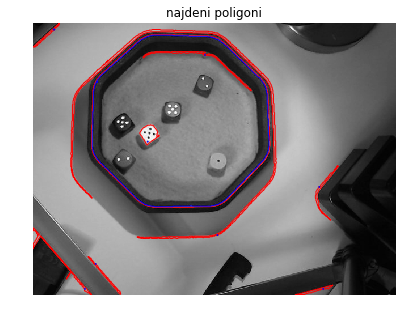

In [22]:
pyplot.figure()
ax = pyplot.gca()

ax.imshow(slika_siva)
ax.set_axis_off()
ax.set_title('najdeni poligoni')

for n in indeks_poli:
    poli = poligoni[n]
    _, _, n_znotraj, n_zunaj = hierarhija[0, n, :]
    
    
    if n_zunaj != -1:
        continue
        
    poli_patch = matplotlib.patches.Polygon(poli[:, 0, :], fill=False, ec='r')
    ax.add_artist(poli_patch)
    
    n_nasl = n_znotraj
    while n_nasl != -1:
        poli_znotraj = poligoni[n_nasl]
        poli_patch = matplotlib.patches.Polygon(poli_znotraj[:, 0, :],
                                                fill=False, ec='b')
        ax.add_artist(poli_patch)

        n_prej, n_nasl, _, _ = hierarhija[0, n_nasl, :]


print(f'število poligonov: {len(indeks_poli)}')

#### Poiščimo pare poligonov podobnih velikosti

V našem primeru mora biti velikost notranjega in zunanjega poligona zelo podobna.

Primerjamo njuni površini, v kolikor je razmerje blizu 1, sta si podobna.

Za minimalno razmerje površin bomo uporabili prag 0.9.

In [23]:
min_prekrivanje = 0.9

indeks_poli_novi = []
for n in indeks_poli:
    m = hierarhija[0, n, 2]
    poligon_zunaj = poligoni[n]
    poligon_notri = poligoni[m]
    
    prekrivanje = cv2.contourArea(poligon_notri)/cv2.contourArea(poligon_zunaj)
    if prekrivanje < min_prekrivanje:
        continue
        
    indeks_poli_novi.append(n)
indeks_poli = indeks_poli_novi

### Izrišimo rezultat

število poligonov: 1


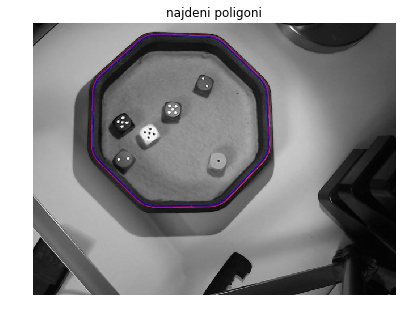

In [24]:
pyplot.figure()
ax = pyplot.gca()

ax.imshow(slika_siva)
ax.set_axis_off()
ax.set_title('najdeni poligoni')

for n in indeks_poli:
    poli = poligoni[n]
    _, _, n_znotraj, n_zunaj = hierarhija[0, n, :]
    
    
    if n_zunaj != -1:
        continue
        
    poli_patch = matplotlib.patches.Polygon(poli[:, 0, :], fill=False, ec='r')
    ax.add_artist(poli_patch)
    
    n_nasl = n_znotraj
    while n_nasl != -1:
        poli_znotraj = poligoni[n_nasl]
        poli_patch = matplotlib.patches.Polygon(poli_znotraj[:, 0, :],
                                                fill=False, ec='b')
        ax.add_artist(poli_patch)

        n_prej, n_nasl, _, _ = hierarhija[0, n_nasl, :]


print(f'število poligonov: {len(indeks_poli)}')

#### Poiščimo poligone, ki so podobni osemkotniku

Za vsak poligon poiščemo približek z manjšim številom točk.

Omejitev v tem primeru je relativna napaka približka.

V kolikor je približek 8-kotnik, potem je poligon primeren.

Prag za relativno napako približka je 2%, oziroma 0.02.

In [25]:
min_oktagon_napaka = 0.02

oktagoni_zunaj = []
oktagoni_notri = []
indeks_poli_novi = []
for n in indeks_poli:
    m = hierarhija[0, n, 2]
    poligon_zunaj = poligoni[n]
    poligon_notri = poligoni[m]
    
    okt_zunaj_napaka = min_oktagon_napaka*cv2.arcLength(poligon_zunaj, True)
    okt_notri_napaka = min_oktagon_napaka*cv2.arcLength(poligon_notri, True)
    
    okt_zunaj = cv2.approxPolyDP(poligon_zunaj, okt_zunaj_napaka, True)
    okt_notri = cv2.approxPolyDP(poligon_notri, okt_notri_napaka, True)

    if len(okt_zunaj) == 8 and len(okt_notri) == 8:
        oktagoni_zunaj.append(okt_zunaj)
        oktagoni_notri.append(okt_notri)
        indeks_poli_novi.append(n)
        
indeks_poli = indeks_poli_novi

#### Izrišimo rezultat

število poligonov: 1


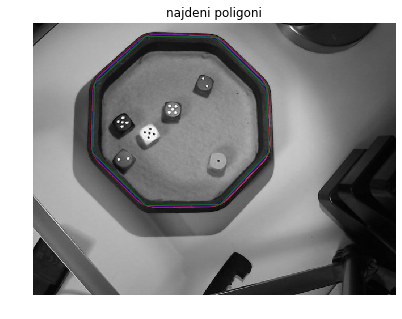

In [26]:
pyplot.figure()
ax = pyplot.gca()

ax.imshow(slika_siva)
ax.set_axis_off()
ax.set_title('najdeni poligoni')

for n in indeks_poli:
    poli = poligoni[n]
    _, _, n_znotraj, n_zunaj = hierarhija[0, n, :]
    
    
    if n_zunaj != -1:
        continue
        
    poli_patch = matplotlib.patches.Polygon(poli[:, 0, :], fill=False, ec='r')
    ax.add_artist(poli_patch)
    
    n_nasl = n_znotraj
    while n_nasl != -1:
        poli_znotraj = poligoni[n_nasl]
        poli_patch = matplotlib.patches.Polygon(poli_znotraj[:, 0, :],
                                                fill=False, ec='b')
        ax.add_artist(poli_patch)

        n_prej, n_nasl, _, _ = hierarhija[0, n_nasl, :]

for okt in oktagoni_zunaj:
    poli_patch = matplotlib.patches.Polygon(okt[:, 0, :], fill=False, ec='g')
    ax.add_artist(poli_patch)

print(f'število poligonov: {len(indeks_poli)}')

#### Izberimo največji poligon

V kolikor imamo v tej točki še vedno več kot enega bomo izbrali največjega.

Če bi imeli možnost več posod, potem bi lahko v nadaljevanju gledali vse poligone.

In [27]:
okt_max = oktagoni_zunaj[0]
v_max = cv2.contourArea(okt_max)

for okt in oktagoni_zunaj[1:]:
    v = cv2.contourArea(okt)
    if v>v_max:
        v_max = v
        okt_max = okt
        
igralno_polje = okt_max

igralno_polje_maska = np.zeros(slika.shape[:2])
igralno_polje_maska = cv2.fillPoly(igralno_polje_maska, [igralno_polje], 1)

#### Izrišimo končno izbiro

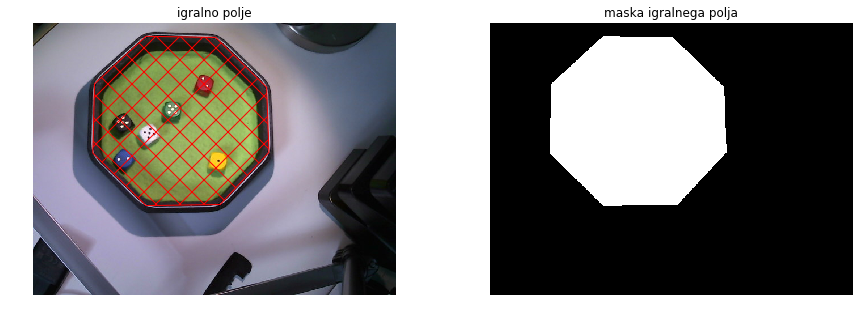

In [28]:
pyplot.figure()
ax = pyplot.subplot(121)
igralno_polje_patch = matplotlib.patches.Polygon(igralno_polje[:, 0, :],
                                                 fill=False, ec='r', hatch='/\\')
ax.imshow(slika)
ax.set_axis_off()
ax.set_title('igralno polje')
ax.add_artist(igralno_polje_patch)

pyplot.subplot(122)
pyplot.imshow(igralno_polje_maska)
pyplot.title('maska igralnega polja')
pyplot.axis('off');

#### Imamo površino, nadaljujmo z detekcijo

Detektirali smo igralno polje in omejili regijo, kjer bomo iskali kocke. 

V nadaljevanju bomo uporabili strojno učenje za detekcijo lokacij in na koncu prepoznavo vrednost kock.